## 라이브러리 불러오기

In [ ]:
!pip install catboost

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

: 

## 데이터 불러오기

In [66]:
dataset_path = '/content/drive/MyDrive/ML_mastery/dataset/'
# id column은 필요없으니 제거
train_dataset = pd.read_csv(dataset_path+'train.csv').drop(['id'],axis=1)
test_dataset = pd.read_csv(dataset_path+'test.csv').drop(['id'],axis=1)

In [67]:
train_dataset.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.31,-25.19,5550
1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63,-24.35,3800
2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.52,-27.02,4400
3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20,-26.17,4850
4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38,-26.84,5700


#### 데이터 결측치 확인

훈련데이터에서 결측치가 총 9개 발견

In [ ]:
for col in train_dataset.columns:
    n_nan = train_dataset[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

: 

테스트 데이터에서 결측치가 총 23개 발견되었다.

In [6]:
for col in test_dataset.columns:
    n_nan = test_dataset[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

        Sex         에서 결측치 개수 : 6개
 Delta 15 N (o/oo)  에서 결측치 개수 : 9개
 Delta 13 C (o/oo)  에서 결측치 개수 : 8개


결측치를 채우기 전에 일단 범주형 데이터를 숫자형 데이터로 처리했다.
- Sex,Clutch Completion 는 male은 1, female은 0, Yes 는 1, No 는 0으로 처리
- Island와 Species는 원 핫 인코딩으로 처리

In [69]:
train_dataset['Sex']=np.where(train_dataset['Sex'].values=='MALE',1,np.where(train_dataset['Sex'].values=='FEMALE',0,np.nan))
test_dataset['Sex']=np.where(test_dataset['Sex'].values=='MALE',1,np.where(test_dataset['Sex'].values=='FEMALE',0,np.nan))
train_dataset['Clutch Completion']=np.where(train_dataset['Clutch Completion'].values=='Yes',1,0)
test_dataset['Clutch Completion']=np.where(test_dataset['Clutch Completion'].values=='Yes',1,0)
train = pd.concat([train_dataset,pd.get_dummies(train_dataset[['Island','Species']])],axis=1)
test = pd.concat([test_dataset,pd.get_dummies(test_dataset[['Island','Species']])],axis=1)
train = train.drop(['Island','Species'],axis=1)
test = test.drop(['Island','Species'],axis=1)

In [70]:
train.head()

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
0,1,50.0,15.3,220,1.0,8.31,-25.19,5550,1,0,0,0,0,1
1,0,49.5,19.0,200,1.0,9.63,-24.35,3800,0,1,0,0,1,0
2,1,45.1,14.4,210,0.0,8.52,-27.02,4400,1,0,0,0,0,1
3,1,44.5,14.7,214,0.0,8.20,-26.17,4850,1,0,0,0,0,1
4,0,49.6,16.0,225,1.0,8.38,-26.84,5700,1,0,0,0,0,1


#### 결측치 채우기

훈련 데이터와 테스트 데이터 모두 같은 ['Sex','Delta 15 N (o/oo)','Delta 13 C (o/oo) ']컬럼들에서 결측치가 나왔다.

이는 데이터 분석을 통해 각 컴럼별 데이터의 상관관계를 파악하고 그에 맞는 데이터를 결측된 값에 넣어주도록 하자

Delta 15 N의 경우 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율이기 때문에 섬별로 차이가 있을 것이란 추정을 했다. 그래서 섬별로 Delta 15N 박스플롯을 그려봤다.

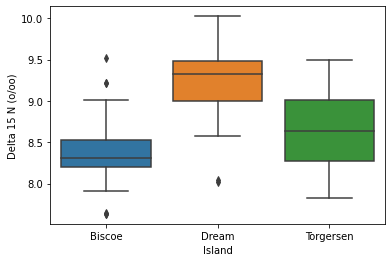

In [9]:
sns.boxplot(x='Island', y='Delta 15 N (o/oo)', data=train_dataset[['Island','Delta 15 N (o/oo)']])
plt.show()

하지만 종과 섬 별로 Delta 15N 그래프를 그려보니 같은 섬이라도 종별로 차이가 있음을 알았다

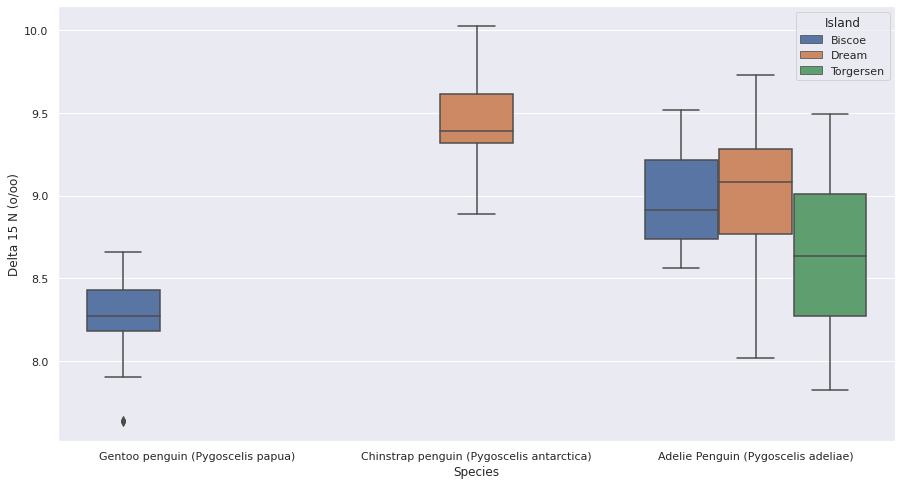

In [10]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='Species', y='Delta 15 N (o/oo)',hue = 'Island', data=train_dataset[['Island','Species','Delta 15 N (o/oo)']])
plt.show()

밑에 그림은 Delta 13 C (o/oo)은 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율이기 때문에 섬, 종별로 차이가 있을 것이라 생각해서 섬과 종별로 Delta 13C의 박스플롯이다.  

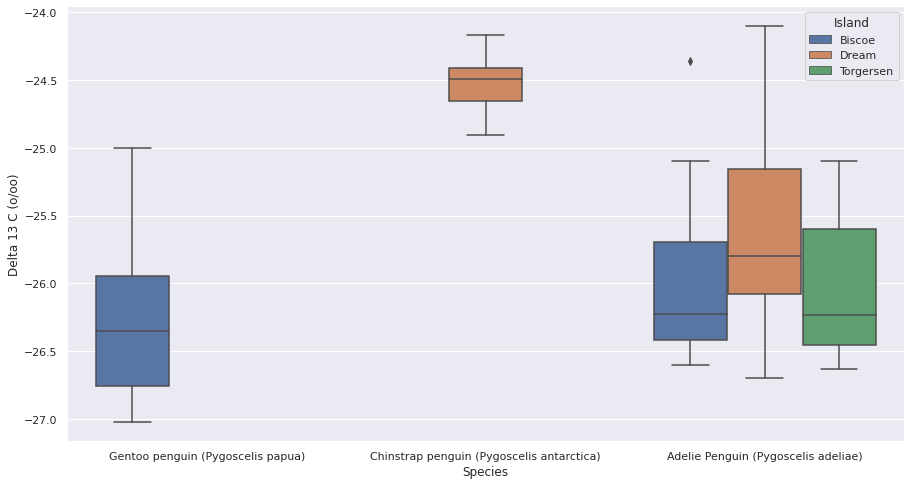

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='Species', y='Delta 13 C (o/oo)',hue = 'Island', data=train_dataset[['Island','Species','Delta 13 C (o/oo)']])
plt.show()

Gentoo 펭귄이나 Chinstrap 펭귄의 경우, 섬하나에서만 살아서 차이가 없지만, Adelie 펭귄의 경우, 3개의 섬 모두 살고 섬마다 약간의 차이가 존재한다.

숫자형 데이터들간의 피어슨 상관계수  
- 피어슨 상관계수 설명 :
피어슨 상관 계수(Pearson Correlation Coefficient ,PCC)란 두 변수 X 와 Y 간의 선형 상관 관계를 계량화한 수치다 . 피어슨 상관 계수는 코시-슈바르츠 부등식에 의해 +1과 -1 사이의 값을 가지며, +1은 완벽한 양의 선형 상관 관계, 0은 선형 상관 관계 없음, -1은 완벽한 음의 선형 상관 관계를 의미한다.  https://ko.wikipedia.org/wiki/%ED%94%BC%EC%96%B4%EC%8A%A8_%EC%83%81%EA%B4%80_%EA%B3%84%EC%88%98
  - 출처 : 위키백과

In [13]:
set_option('precision',2)
train.corr(method='pearson')

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
Clutch Completion,1.00,-0.12,-0.21,0.11,-1.13e-01,-0.28,-0.29,0.09,2.29e-01,-3.15e-01,0.12,0.08,-0.30,0.18
Culmen Length (mm),-0.12,1.00,-0.25,0.67,3.24e-01,-0.04,0.11,0.57,2.97e-01,-4.72e-02,-0.39,-0.82,0.38,0.48
Culmen Depth (mm),-0.21,-0.25,1.00,-0.60,3.69e-01,0.65,0.48,-0.49,-7.25e-01,5.60e-01,0.28,0.52,0.38,-0.83
Flipper Length (mm),0.11,0.67,-0.60,1.00,2.51e-01,-0.53,-0.45,0.86,7.40e-01,-5.66e-01,-0.30,-0.69,-0.25,0.88
Sex,-0.11,0.32,0.37,0.25,1.00e+00,0.14,-0.10,0.42,-9.09e-03,-7.30e-03,0.03,0.05,-0.07,0.01
Delta 15 N (o/oo),-0.28,-0.04,0.65,-0.53,1.36e-01,1.00,0.64,-0.55,-6.44e-01,7.03e-01,-0.07,0.17,0.65,-0.71
Delta 13 C (o/oo),-0.29,0.11,0.48,-0.45,-9.94e-02,0.64,1.00,-0.47,-5.89e-01,6.74e-01,-0.11,-0.09,0.76,-0.56
Body Mass (g),0.09,0.57,-0.49,0.86,4.20e-01,-0.55,-0.47,1.00,7.08e-01,-5.74e-01,-0.24,-0.51,-0.39,0.82
Island_Biscoe,0.23,0.30,-0.72,0.74,-9.09e-03,-0.64,-0.59,0.71,1.00e+00,-7.93e-01,-0.36,-0.42,-0.53,0.85
Island_Dream,-0.32,-0.05,0.56,-0.57,-7.30e-03,0.70,0.67,-0.57,-7.93e-01,1.00e+00,-0.28,0.12,0.67,-0.68


#### Sex 결측치 채우기

Sex와 강한 상관관계를 가지는 변수들은 없다.
그래서 그냥 ML알고리즘으로 Sex값을 예측해서 결측치를 채워넣기로 했다.

In [75]:
train.columns

Index(['Clutch Completion', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)'],
      dtype='object')

In [76]:
sex_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'
       ]



다양한 알고리즘 비교를 통해 성별 예측을 잘하는 최선의 알고리즘을 찾아봤다. 

In [79]:
models = []
models.append(('LR',LogisticRegression(solver='liblinear',multi_class = 'ovr')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))
models.append(('XGBC',XGBClassifier(iterations=10000,verbose=False)))
models.append(('LGBMC',LGBMClassifier()))
models.append(('AdaC',AdaBoostClassifier()))
models.append(('Cat',CatBoostClassifier(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[sex_features].iloc[train['Sex'].dropna().index]
                               ,train['Sex'].iloc[train['Sex'].dropna().index]
                               ,cv= kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : 0.735606 (0.100186) 
LDA : 0.869697 (0.085964) 
KNN : 0.756818 (0.118601) 
CART : 0.791667 (0.098149) 
NB : 0.761364 (0.113041) 
SVM : 0.756818 (0.095433) 
RFC : 0.834848 (0.056367) 
XGBC : 0.790909 (0.092672) 
LGBMC : 0.806818 (0.053702) 
AdaC : 0.885606 (0.055510) 
Cat : 0.815152 (0.047937) 


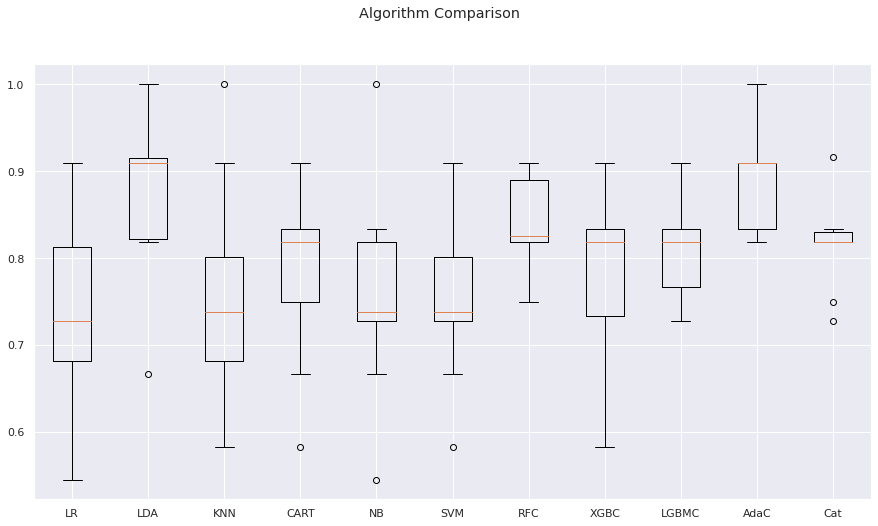

In [80]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

정확도는 AdaBoost가 가장 안정적으로 높으므로 AdaBoost를 통해 결측치를 채울것이다.

In [71]:
sex_model = AdaBoostClassifier()
sex_model.fit(train[sex_features].iloc[train['Sex'].dropna().index],train['Sex'].iloc[train['Sex'].dropna().index])
train['Sex'].iloc[np.where(train['Sex'].isnull()==True)] =  sex_model.predict(train[train['Sex'].isnull()][sex_features])
test['Sex'].iloc[np.where(test['Sex'].isnull()==True)] =  sex_model.predict(test[test['Sex'].isnull()][sex_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Delta 15 N 결측치 채우기

다른 결측치도 같은 방법을 사용해보았다. 성별 예측은 분류지만 Delta 15N과 Delta 13C는 회귀이다.

In [82]:
Delta_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen','Sex'
       ]

In [85]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(iterations=10000,verbose=False)))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[Delta_features].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,train['Delta 15 N (o/oo)'].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,cv= kfold,scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -0.116568 (0.036340) 
LASSO : -0.238135 (0.090412) 
KNN : -0.159055 (0.078713) 
CART : -0.211358 (0.158760) 
EN : -0.211953 (0.079840) 
SVM : -0.232461 (0.090579) 
RFC : -0.142729 (0.072747) 
[05:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:10] WARNING: /workspace/src/object

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Cat : -0.154403 (0.073445) 


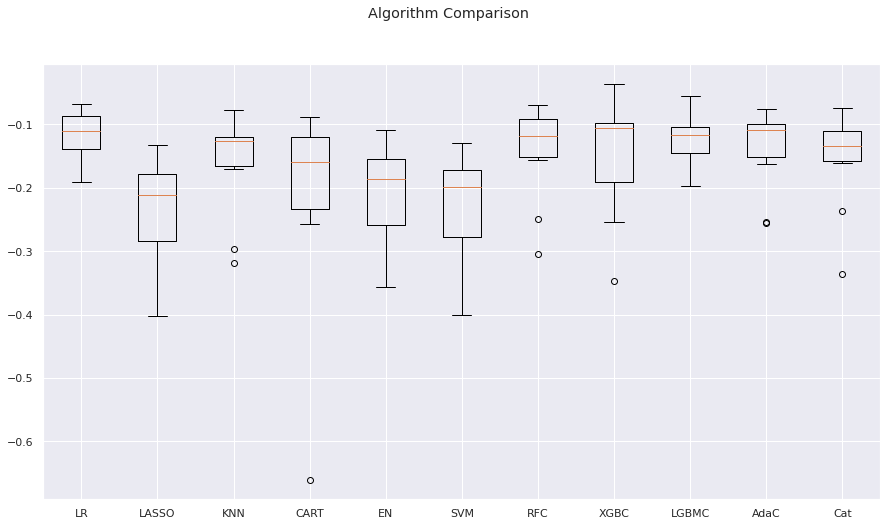

In [86]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

AdaBoost가 가장 안정적으로 로스가 적으므로 Adaboost를 사용하겠다.

In [92]:
d15_model = AdaBoostRegressor()
d15_model.fit(train[Delta_features].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,train['Delta 15 N (o/oo)'].iloc[train['Delta 15 N (o/oo)'].dropna().index])
train['Delta 15 N (o/oo)'].iloc[np.where(train['Delta 15 N (o/oo)'].isnull()==True)] =  d15_model.predict(train[train['Delta 15 N (o/oo)'].isnull()][Delta_features])
test['Delta 15 N (o/oo)'].iloc[np.where(test['Delta 15 N (o/oo)'].isnull()==True)] =  d15_model.predict(test[test['Delta 15 N (o/oo)'].isnull()][Delta_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Delta 13 C 결측치 채우기

In [94]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(iterations=10000,verbose=False)))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[Delta_features].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,train['Delta 13 C (o/oo)'].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,cv= kfold,scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -0.282013 (0.152863) 
LASSO : -0.478706 (0.192187) 
KNN : -0.415174 (0.254843) 
CART : -0.495830 (0.232488) 
EN : -0.396727 (0.177711) 
SVM : -0.634220 (0.269142) 
RFR : -0.350787 (0.171853) 
[05:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:51] WARNING: /workspace/src/object

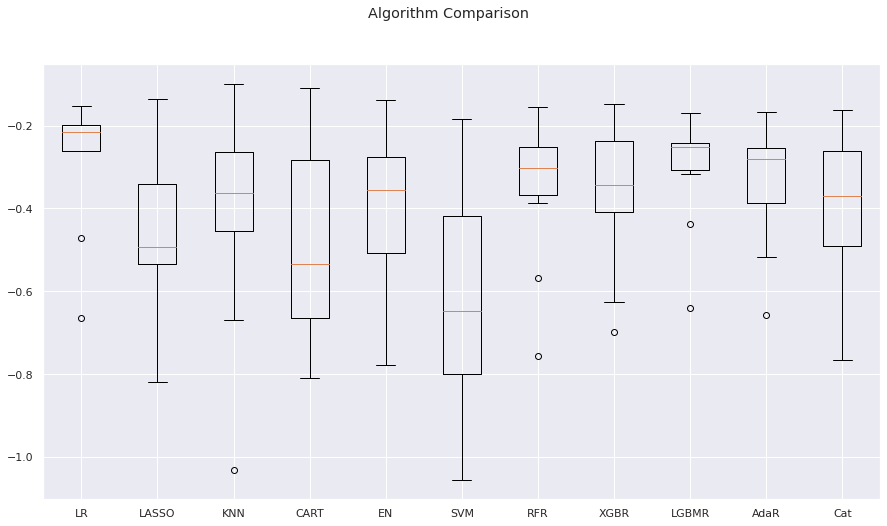

In [95]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR 이 가장 안정적으로 로스가 적으므로 LR를 사용하겠다.

In [98]:
d13_model = LinearRegression()
d13_model.fit(train[Delta_features].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,train['Delta 13 C (o/oo)'].iloc[train['Delta 13 C (o/oo)'].dropna().index])
train['Delta 13 C (o/oo)'].iloc[np.where(train['Delta 13 C (o/oo)'].isnull()==True)] =  d13_model.predict(train[train['Delta 13 C (o/oo)'].isnull()][Delta_features])
test['Delta 13 C (o/oo)'].iloc[np.where(test['Delta 13 C (o/oo)'].isnull()==True)] =  d13_model.predict(test[test['Delta 13 C (o/oo)'].isnull()][Delta_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [99]:
for col in test.columns:
    n_nan = test[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

## 데이터 표현

In [103]:
print(train.shape)

(114, 14)


In [104]:
print(train.dtypes)

Clutch Completion                                      int64
Culmen Length (mm)                                   float64
Culmen Depth (mm)                                    float64
Flipper Length (mm)                                    int64
Sex                                                  float64
Delta 15 N (o/oo)                                    float64
Delta 13 C (o/oo)                                    float64
Body Mass (g)                                          int64
Island_Biscoe                                          uint8
Island_Dream                                           uint8
Island_Torgersen                                       uint8
Species_Adelie Penguin (Pygoscelis adeliae)            uint8
Species_Chinstrap penguin (Pygoscelis antarctica)      uint8
Species_Gentoo penguin (Pygoscelis papua)              uint8
dtype: object


train 데이터 히스토그램

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed52c612d0>,
      dtype=object)

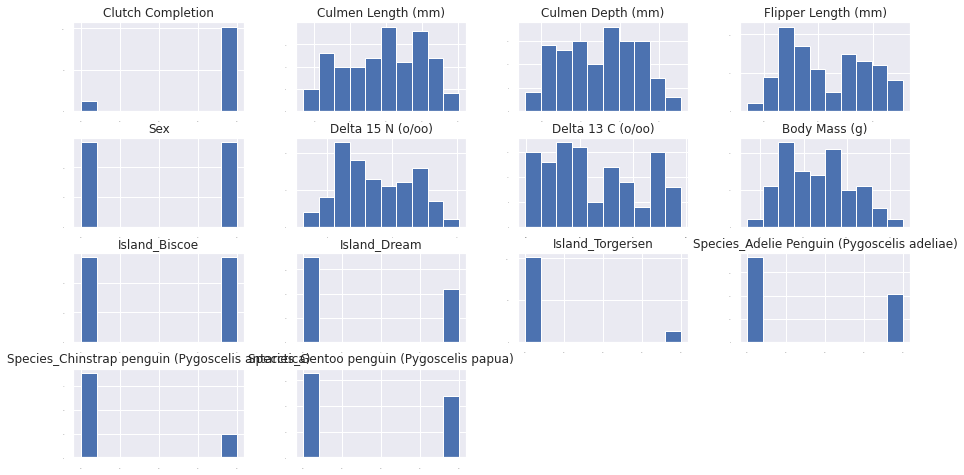

In [107]:
train.hist(sharex=False,sharey=False,xlabelsize = 1,ylabelsize=1)

density plot으로 표현

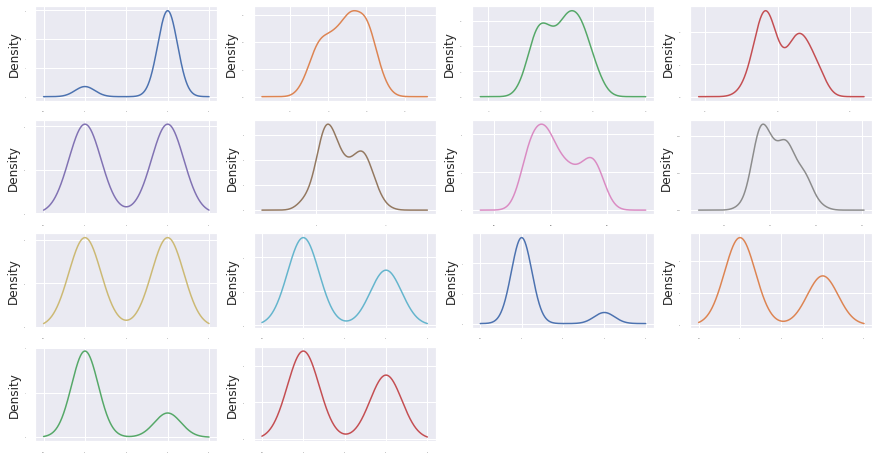

In [109]:
train.plot(kind='density',subplots = True,layout = (4,4),sharex=False,sharey=False,legend=False,fontsize=1)
plt.show()

box plot으로 표현

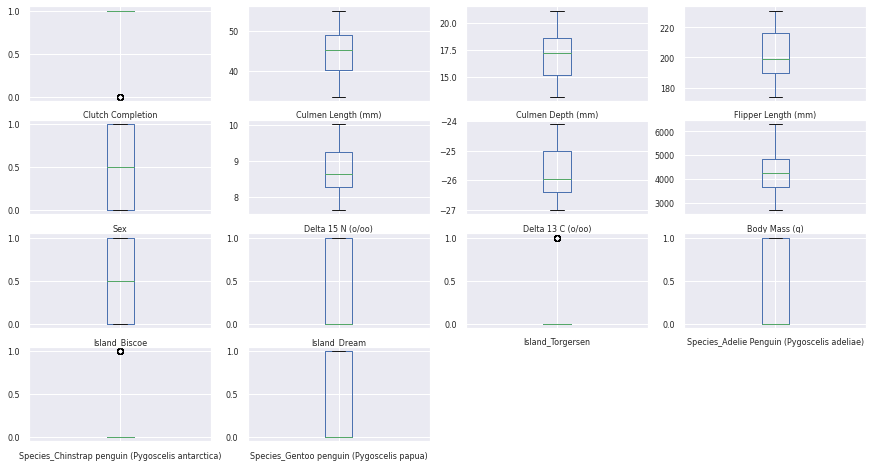

In [111]:
train.plot(kind='box',subplots=True,layout=(4,4),sharex=False,sharey=False,legend=False,fontsize=8)
plt.show()

## 알고리즘 평가

#### Base

In [117]:
train.columns

Index(['Clutch Completion', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)'],
      dtype='object')

In [114]:
num_folds= 10
seed = 7
scoring = 'neg_root_mean_squared_error'

In [188]:
X_all = train[test.columns.tolist()]
y_all =train['Body Mass (g)']

In [118]:
X_train, X_valid, y_train, y_valid = train_test_split(train[test.columns.tolist()],train['Body Mass (g)']
                                                      ,test_size=0.2,random_state=seed)


In [125]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor()))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(verbose=False)))
models.append(('Xtree',ExtraTreesRegressor()))

results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -330.882599 (56.805786) 
LASSO : -329.400922 (55.665622) 
KNN : -388.766440 (54.708975) 
CART : -419.970274 (82.301762) 
EN : -376.161878 (58.119870) 
SVM : -775.629940 (193.158682) 
RFR : -331.316962 (86.479104) 
[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:10:05] WARNING:

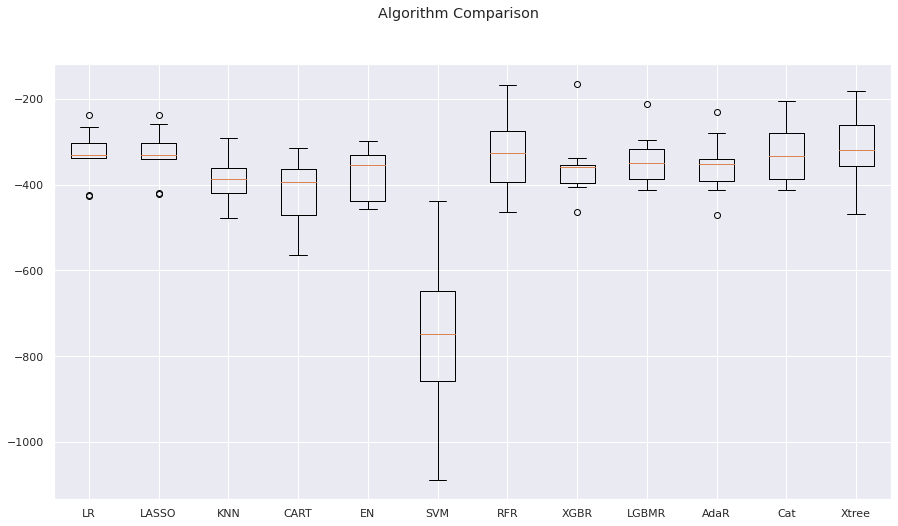

In [126]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### standardization

이번엔 데이터를 standardization을 한 후 알고리즘 평가를 해보겠다.

In [141]:
pipelines = []
pipelines.append(('ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('SVM',SVR())])))
pipelines.append(('ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('RFR',RandomForestRegressor())])))
pipelines.append(('ScaledXGBR',Pipeline([('Scaler',preprocessing.StandardScaler()),('XGBR',XGBRegressor())])))
pipelines.append(('ScaledLGBMR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LGBMR',LGBMRegressor())])))
pipelines.append(('ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('ScaledCat',Pipeline([('Scaler',preprocessing.StandardScaler()),('Cat',CatBoostRegressor(verbose=False))])))
pipelines.append(('ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('Xtree',ExtraTreesRegressor())])))

results_scaled =[]
names_scaled = []
for name, model in pipelines:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results_scaled.append(cv_results)
  names_scaled.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

ScaledLR : -330.882599 (56.805786) 
ScaledLASSO : -330.559931 (55.625149) 
ScaledKNN : -344.411139 (69.674407) 
ScaledCART : -421.642256 (74.478014) 
ScaledEN : -343.820812 (61.649479) 
ScaledSVM : -767.472955 (192.286368) 
ScaledRFR : -331.271437 (81.224474) 
[06:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favo

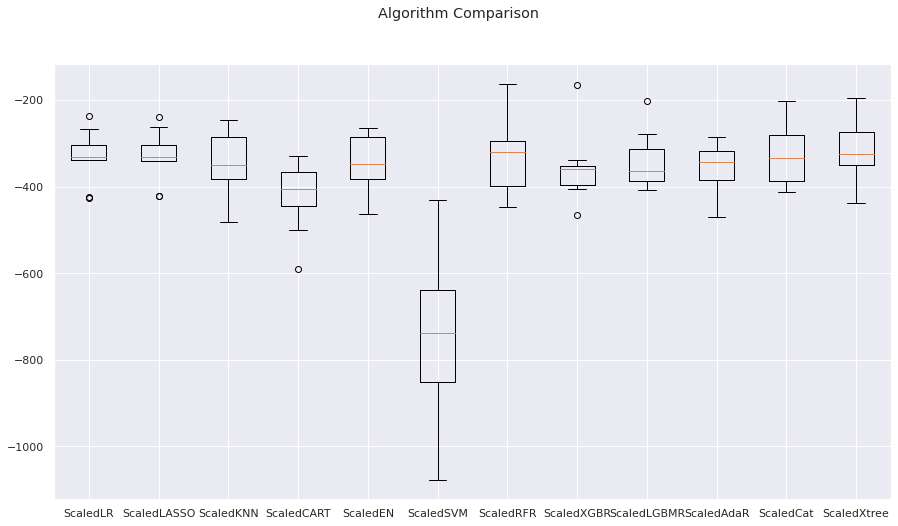

In [142]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_scaled)
ax.set_xticklabels(names_scaled)
plt.show()

#### Normalization

In [143]:
pipelines = []
pipelines.append(('NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('LR',LinearRegression())])))
pipelines.append(('NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('LASSO',Lasso())])))
pipelines.append(('NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('KNN',KNeighborsRegressor())])))
pipelines.append(('NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('CART',DecisionTreeRegressor())])))
pipelines.append(('NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('EN',ElasticNet())])))
pipelines.append(('NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('SVM',SVR())])))
pipelines.append(('NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('RFR',RandomForestRegressor())])))
pipelines.append(('NormXGBR',Pipeline([('Scaler',preprocessing.Normalizer()),('XGBR',XGBRegressor())])))
pipelines.append(('NormLGBMR',Pipeline([('Scaler',preprocessing.Normalizer()),('LGBMR',LGBMRegressor())])))
pipelines.append(('NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('NormCat',Pipeline([('Scaler',preprocessing.Normalizer()),('Cat',CatBoostRegressor(verbose=False))])))
pipelines.append(('NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('Xtree',ExtraTreesRegressor())])))

results_norm =[]
names_norm = []
for name, model in pipelines:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results_norm.append(cv_results)
  names_norm.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

NormLR : -336.564193 (52.794640) 
NormLASSO : -535.719858 (76.347646) 
NormKNN : -384.641645 (42.751212) 
NormCART : -393.466309 (111.022208) 
NormEN : -771.844080 (171.084723) 
NormSVM : -776.125072 (193.274444) 
NormRFR : -335.729938 (88.716869) 
[06:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

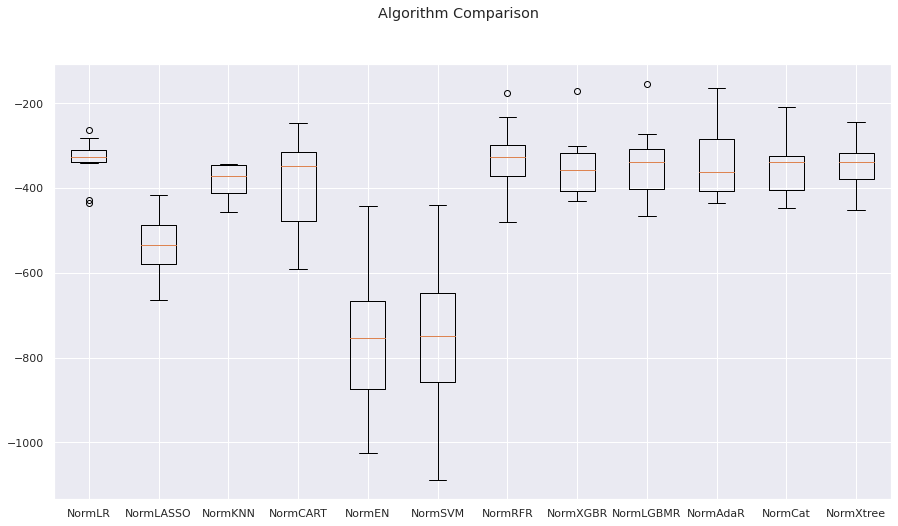

In [144]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_norm)
ax.set_xticklabels(names_norm)
plt.show()

#### scaled 알고리즘 비교

평균값 비교

In [180]:
compare_algo_mean = pd.DataFrame([ i.mean() for i in results],columns=['Base'],index=names)
compare_algo_mean['Stand'] = [ i.mean() for i in results_scaled]
compare_algo_mean['Norm'] = [ i.mean() for i in results_norm]


<Figure size 1152x576 with 0 Axes>

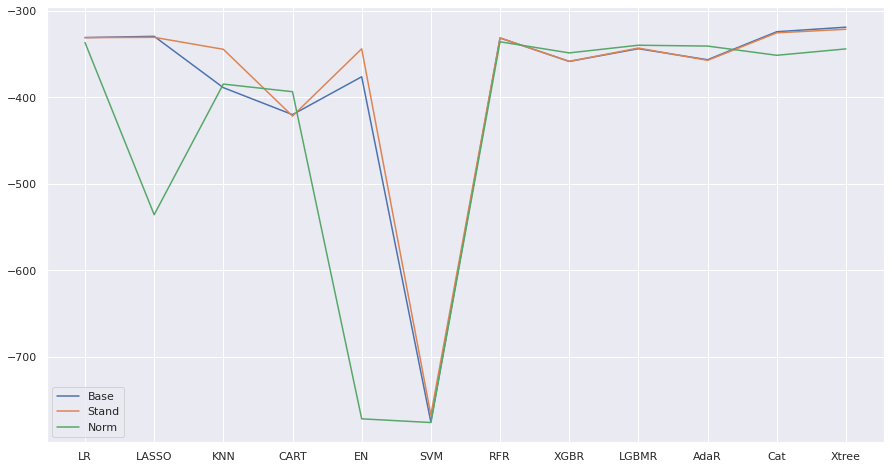

In [181]:
plt.figure(figsize=(16,8))
ax =compare_algo_mean.plot()
plt.xticks(range(len(compare_algo_mean.index)), compare_algo_mean.index)
plt.show()

중간값 비교

In [184]:
compare_algo_mid = pd.DataFrame([ np.median(i) for i in results],columns=['Base'],index=names)
compare_algo_mid['Stand'] = [ np.median(i)for i in results_scaled]
compare_algo_mid['Norm'] = [ np.median(i) for i in results_norm]

<Figure size 1152x576 with 0 Axes>

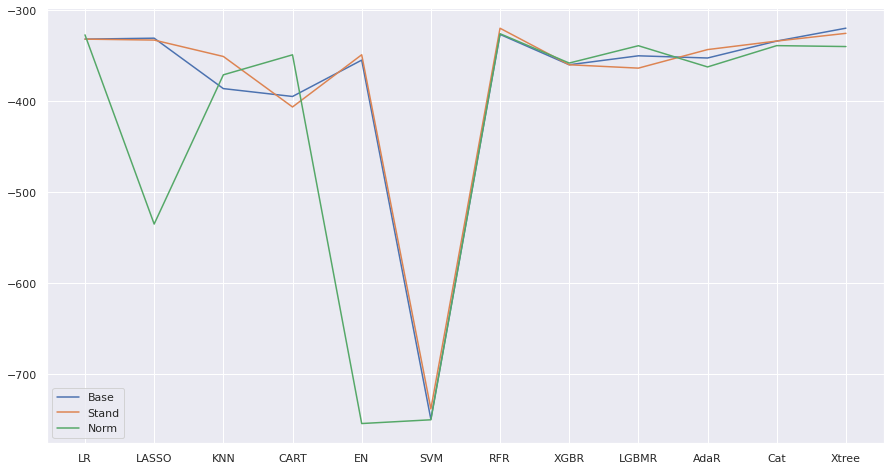

In [185]:
plt.figure(figsize=(16,8))
ax =compare_algo_mid.plot()
plt.xticks(range(len(compare_algo_mid.index)), compare_algo_mid.index)
plt.show()

알고리즘들을 비교해봤을 때,  
 standardization한 RF,Lasso, Extratree, CatBoost, standardization한 LR 등 이 가장 우수한 것을 알 수 있었다.  

## Improve Algorithm with Tuning

#### RF Tuning

In [196]:
scaler = preprocessing.StandardScaler().fit(X_all)
scaled_X = scaler.transform(X_all)
params = { 'n_estimators' : [10, 50,100],
           'max_depth' : [6, 12,18,24],
           'min_samples_leaf' : [1, 6, 12, 18],
           'min_samples_split' : [2, 8, 16, 20]
            }
model = RandomForestRegressor()
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(scaled_X,y_all)

In [197]:
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best : -325.098710 using {'max_depth': 24, 'min_samples_leaf': 12, 'min_samples_split': 16, 'n_estimators': 10} 


#### Extra Tree Tuning

In [198]:
params = { 'n_estimators' : [10, 50,100],
           'max_depth' : [6,12,18,24],
           'min_samples_leaf' : [1, 6, 12, 18],
           'min_samples_split' : [2,4,8, 16]
            }
model =ExtraTreesRegressor()
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)

In [199]:
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best : -306.784238 using {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10} 


## 앙상블

In [200]:
from sklearn.metrics import mean_squared_error
import math 

In [264]:
errors = []
pred_valid=[]
pred_test = []

In [265]:
scaler = preprocessing.StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)
scaled_X_test = scaler.transform(test)

Lasso

In [266]:
lasso = Lasso()
lasso.fit(X_train,y_train)
lasso_valid = lasso.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lasso_valid))
errors.append(('Lasso',rmse))
pred_valid.append(('Lasso',lasso_valid))
lasso_test = lasso.predict(test)
pred_test.append(('Lasso',lasso_test))

scaled LR

In [267]:
LR =LinearRegression()
LR.fit(scaled_X_train,y_train)
lr_valid = LR.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lr_valid))
errors.append(('LR',rmse))
pred_valid.append(('LR',lr_valid))
lr_test = LR.predict(scaled_X_test)
pred_test.append(('LR',lr_test))

Scaled RF

In [268]:
RF =RandomForestRegressor(max_depth= 24, min_samples_leaf= 12, min_samples_split= 16, n_estimators= 10)
RF.fit(scaled_X_train,y_train)
rf_valid = RF.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, rf_valid))
errors.append(('RF',rmse))
pred_valid.append(('RF',rf_valid))
rf_test = RF.predict(scaled_X_test)
pred_test.append(('RF',rf_test))

Extra Tree

In [269]:
ET =ExtraTreesRegressor(max_depth=24, min_samples_leaf= 1, min_samples_split= 8, n_estimators= 10)
ET.fit(X_train,y_train)
et_valid = ET.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, et_valid))
errors.append(('ET',rmse))
pred_valid.append(('ET',et_valid))
et_test = ET.predict(test)
pred_test.append(('ET',et_test))

CatBoost

In [270]:
CAT = CatBoostRegressor(iterations=10000,random_state=7 
           ,eval_metric="RMSE")
CAT.fit(X_train,y_train, eval_set=[(X_valid,y_valid)],early_stopping_rounds=300
        ,verbose=1000 )
cat_valid = CAT.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, cat_valid))
errors.append(('CAT',rmse))
pred_valid.append(('CAT',cat_valid))
cat_test = CAT.predict(test)
pred_test.append(('CAT',cat_test))

Learning rate set to 0.00858
0:	learn: 773.3188232	test: 779.5634198	best: 779.5634198 (0)	total: 2.83ms	remaining: 28.3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 322.4591944
bestIteration = 534

Shrink model to first 535 iterations.


In [271]:
for name, error in errors:
  print("{} : {}".format(name,error))

Lasso : 290.1474597842362
LR : 294.31302093463603
RF : 340.6074309931279
ET : 313.4276644800703
CAT : 322.4591944233891


각 5개의 모델이 예측한 값을 정확하게 0.2로 나눠서 더하면 RMSE값이 감소함을 볼 수 있었다.
    
RF의 성능이 가장 안좋아서 본인의 경우 RF를 제외한 4개의 모델의 예측값에 0.25를 곱하고 더했더니 더 좋은 결과가 나왔다.

In [280]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  val+= (0.2* pred)
math.sqrt(mean_squared_error(y_valid, val))

290.68622466662885

In [281]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  if name == 'Lasso' or name=='LR' or name == 'ET' or name=='CAT':
    val+= (0.25* pred)
math.sqrt(mean_squared_error(y_valid, val))

286.6892744264773

이 방법으로 테스트 데이터 예측값 혼합

In [283]:
test_val= np.zeros(test.shape[0])
for name, pred in pred_test:
  if name == 'Lasso' or name=='LR' or name == 'ET' or name=='CAT':
    test_val+= (0.25* pred)


## 제출

In [286]:
submission = pd.read_csv(dataset_path+'sample_submission.csv')
submission['Body Mass (g)'] = test_val
submission.to_csv(dataset_path+"20211229.csv", index=False)

[Public 스코어 : 285.30128]

## 후기  
다른 분들 코드나 내 모델 비교를 해보니 선형 모델들이 스코어가 잘 나오는 것으로 보인다. 다른 분들은 모델을 만들때, 선형모델들을 적극 고려보기길 추천한다.